## Inferring parameters from images

In the example that follows, we consider a simple setup where the data points generated by the simulator model are high-dimensional (32x32 grayscale images) and we use a convolutional neural network as summary statistics extractor.

First of all, we import all the packages required for running the tutorial

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sbi import analysis, utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

seed = 0
torch.manual_seed(seed);
%matplotlib widget

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### The simulator model

The simulator model that we consider has two parameters: $r$ and $\theta$. On each run, it generates 100 two-dimensional points centered around $(r \cos(\theta), r \sin(\theta))$ and perturbed by a Gaussian noise with variance 0.01. Instead of simply outputting the $(x,y)$ coordinates of each data point, the model generates a grayscale image of the scattered points with dimensions 32 by 32. This image is further perturbed by an uniform noise with values betweeen 0 and 0.2. The code below defines such model.


In [8]:
def simulator_model(parameter, return_points=False):
    """Simulator model with two-dimensional input parameter and 1024-D output

    This simulator serves as a basic example for using a neural net for learning
    summary features. It has only two input parameters but generates
    high-dimensional output vectors. The data is generated as follows:
        (-) Input:  parameter = [r, phi] (1) Generate 100 two-dimensional
        points centered around (r cos(phi),r sin(phi))
            and perturbed by a Gaussian noise with variance 0.01
        (2) Create a grayscale image I of the scattered points with dimensions
            32 by 32
        (3) Perturb I with an uniform noise with values betweeen 0 and 0.2
        (-) Output: I

    Parameters
    ----------
    parameter : array-like, shape (2)
        The two input parameters of the model, ordered as [r, phi]
    return_points : bool (default: False)
        Whether the simulator should return the coordinates of the simulated
        data points as well

    Returns
    -------
    I: torch tensor, shape (1, 1024)
        Output flattened image
    (optional) points: array-like, shape (100, 2)
        Coordinates of the 2D simulated data points

    """
    r = parameter[0]
    phi = parameter[1]

    sigma_points = 0.10
    npoints = 100
    points = []
    for _ in range(npoints):
        x = r * torch.cos(phi) + sigma_points * torch.randn(1)
        y = r * torch.sin(phi) + sigma_points * torch.randn(1)
        points.append([x, y])
    points = torch.as_tensor(points)

    nx = 32
    ny = 32
    sigma_image = 0.20
    im = torch.zeros(nx, ny)
    for point in points:
        pi = int((point[0] - (-1)) / ((+1) - (-1)) * nx)
        pj = int((point[1] - (-1)) / ((+1) - (-1)) * ny)
        if (pi < nx) and (pj < ny):
            im[pi, pj] = 1
    im = im + sigma_image * torch.rand(nx, ny)
    im = im.T
    im = im.reshape(1, -1)

    if return_points:
        return im, points
    else:
        return im

The figure below shows an example of the output of the simulator when $r = 0.70$ and $\theta = \pi/4$


Text(0.5, 1.0, 'noisy observed data (gray image with 32 x 32 pixels)')

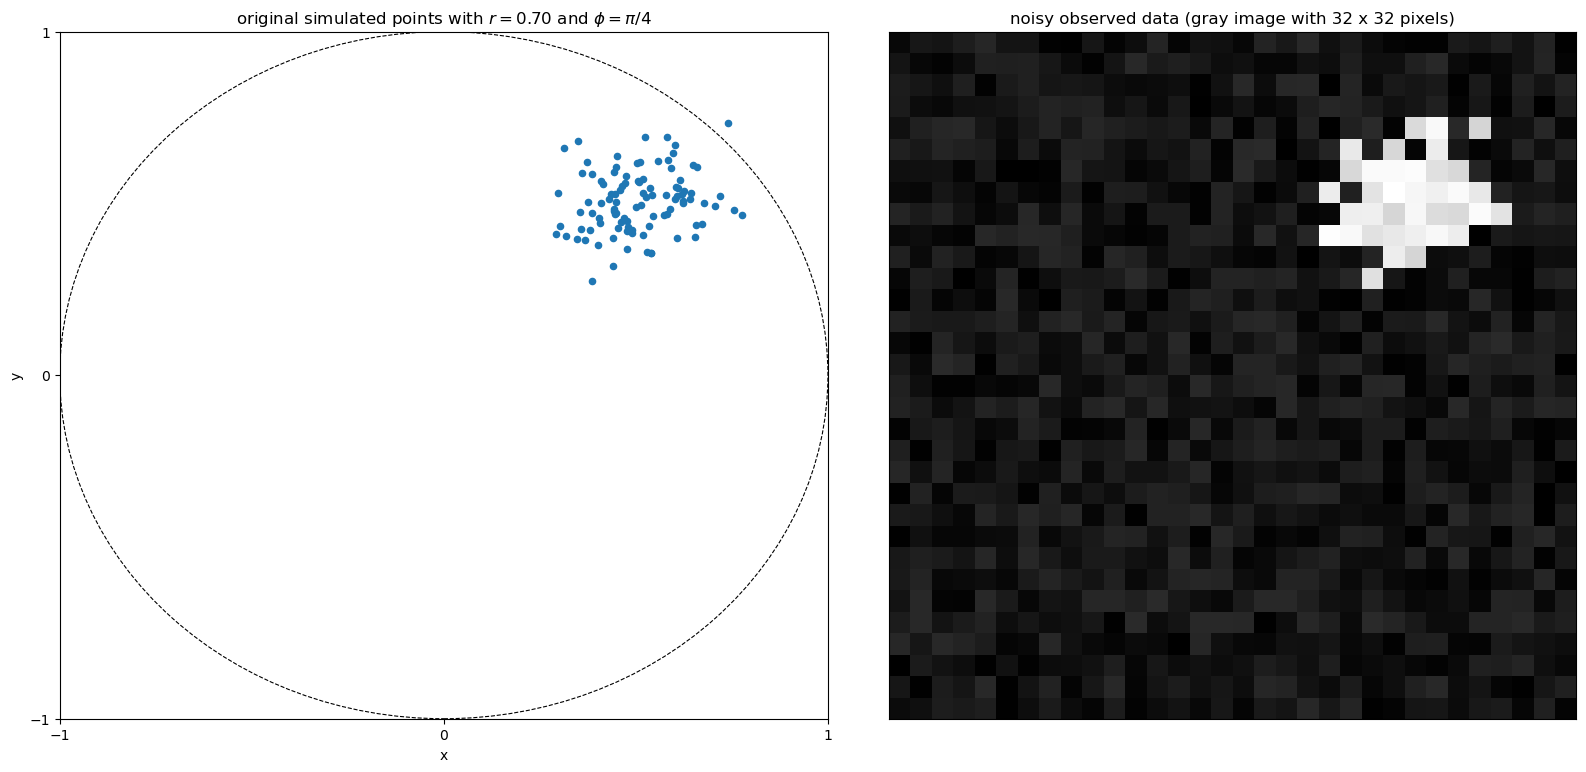

In [9]:
# simulate samples
true_parameter = torch.tensor([0.70, torch.pi / 4])
x_observed, x_points = simulator_model(true_parameter, return_points=True)

# plot the observation
fig, ax = plt.subplots(
    facecolor="white", figsize=(16.15, 7.61), ncols=2, constrained_layout=True
)
circle = plt.Circle((0, 0), 1.0, color="k", ls="--", lw=0.8, fill=False)
ax[0].add_artist(circle)
ax[0].scatter(x_points[:, 0], x_points[:, 1], s=20)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_xlim(-1, +1)
ax[0].set_xticks([-1, 0.0, +1.0])
ax[0].set_ylim(-1, +1)
ax[0].set_yticks([-1, 0.0, +1.0])
ax[0].set_title(r"original simulated points with $r = 0.70$ and $\phi = \pi/4$")
ax[1].imshow(x_observed.view(32, 32), origin="lower", cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("noisy observed data (gray image with 32 x 32 pixels)")

## Choosing an `embedding_net`

The outputs $x$ from the simulator are defined in a 1024 dimensional space (32 x 32 = 1024). To avoid having to setup a conditional neural density estimator to work directly on such high-dimensional vectors, one could use an `embedding_net` that would take the images as input and encode them into smaller vectors.

`sbi` provides pre-configured embedding networks of the following types:

- Fully-connected multi-layer perceptron
- Convolutional neural network (1D and 2D convolutions)
- Permutation-invariant neural network (for trial-based data, see [here](https://sbi-dev.github.io/sbi/latest/tutorials/12_iid_data_and_permutation_invariant_embeddings/))

In the example considered here, the most appropriate `embedding_net` would be a CNN for two-dimensional images. We can setup it as per:


In [10]:
from sbi.neural_nets.embedding_nets import CNNEmbedding

embedding_net = CNNEmbedding(
    input_shape=(32, 32),
    in_channels=1,
    out_channels_per_layer=[6],
    num_conv_layers=1,
    num_linear_layers=1,
    output_dim=8,
    kernel_size=5,
    pool_kernel_size=8
)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

!!! note
    See [here](https://github.com/sbi-dev/sbi/blob/main/sbi/neural_nets/embedding_nets.py) for details on all hyperparametes for each available embedding net in `sbi`

## The inference procedure

With the `embedding_net` defined and instantiated, we can follow the usual workflow of an inference procedure in `sbi`. The `embedding_net` object appears as an input argument when instantiating the neural density estimator with `sbi.neural_nets.posterior_nn`.


In [15]:
# set prior distribution for the parameters
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 2 * torch.pi])
)

# make a SBI-wrapper on the simulator object for compatibility
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator_model, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [16]:
from sbi.neural_nets import posterior_nn

# instantiate the neural density estimator
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# setup the inference procedure with NPE
inferer = NPE(prior=prior, density_estimator=neural_posterior)

In [ ]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10_000)

In [ ]:
density_estimator = inferer.append_simulations(theta, x).train(training_batch_size=256)
posterior = inferer.build_posterior(density_estimator)

## Visualizing the results

We now generate 50000 samples of the posterior distribution of $r$ and $\theta$ when observing an input data point $x$ generated from the `simulator model` with $r = 0.70$ and $\theta = \pi/4$.


In [ ]:
# generate posterior samples
true_parameter = torch.tensor([0.7, torch.pi / 4])
x_observed = simulator_model(true_parameter)
samples = posterior.set_default_x(x_observed).sample((50000,))

The figure below shows the statistics of the generated samples.


In [ ]:
# create the figure
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter,
    labels=["r", r"$\phi$"],
    limits=[[0, 1], [0, 2 * torch.pi]],
    fig_kwargs=dict(
        points_colors="r",
        points_offdiag={"markersize": 6},
    ),
    figsize=(5, 5),
)